#INSTALL AND IMPORT DEPENDENCIES

In [ ]:
!pip install git+https://github.com/GabrieleSgroi/genetic_algorithm
!sudo apt update
!sudo apt-get install -y xvfb ffmpeg
# !pip install gym[all]


!pip install  pyvirtualdisplay
# !pip install box2d-py
!pip install ufal.pybox2d
!pip install gymnasium
!pip install pygame

import os
import numpy as np
import genetic_alg
from genetic_alg.ga import GeneticAlg
from genetic_alg.mutations import gaussian_mutation
from genetic_alg.crossovers import single_point_crossover
from genetic_alg.selections import rank_selection, boltzmann_selection
from genetic_alg.utils import load_ga, flatten_weights, reshape_weights
import IPython
import pyvirtualdisplay
import base64
import imageio
import gym
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Lambda
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

  Cloning https://github.com/GabrieleSgroi/genetic_algorithm to /tmp/pip-req-build-ygeb22qo
  Running command git clone --filter=blob:none --quiet https://github.com/GabrieleSgroi/genetic_algorithm /tmp/pip-req-build-ygeb22qo
  Resolved https://github.com/GabrieleSgroi/genetic_algorithm to commit 81aea313feaaeb1734f461557473a1a7704ae719
  Preparing metadata (setup.py) ... done
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu ja

NameNotFound: Environment LunarLander-v2continuous doesn't exist. Did you mean: `LunarLanderContinuous`?

In [ ]:
env = gym.make("LunarLanderContinuous-v2")
print(env.action_space)
print(env.observation_space)

Box(-1.0, 1.0, (2,), float32)
Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


We use the continuous version of the lunar lander environment present in OpenAI Gym.

The action consists of a two-dimensional vector with values bounded between -1 and 1. The first entry controls the main engine: it varies the power from 0 (-1) to 100% (+1). The main engine cannot work below 50% power. The second entry controls the lateral engines: in the interval [-1, -0,5] fires the left engine, in the interval [-0.5, 0.5] turn the side engines off, [0.5, 1] fires the right engine.

The observed state is a 8-dimensional vector consisting of:
- x coordinate of the lander;
- y coordinate of the lander;
- horizontal velocity;
- vertical velocity;
- angle of the lander;
- angular velocity of the lander around its center;
- boolean indicating contact of left leg with the ground;
- boolean indicating contact of right leg with the ground.

The landing pad is located at the origin.

#EVALUATION UTILITIES

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, env, filename, num_episodes=3, fps=30):
  '''Create a video of the given policy'''
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      done=False
      obs= np.asarray(env.reset())
      obs=np.expand_dims(obs, axis=0)
      video.append_data(env.render(mode='rgb_array'))
      reward=0
      frame_counter=0
      while not done:
        if filename=='random.mp4':
          action=policy.predict(obs)[0]
        else:
          action=np.argmax(model.predict(obs, verbose=0)[0])
        obs, rew, done, info = env.step(action)
        reward+=rew
        obs=np.expand_dims(np.array(obs), axis=0)
        video.append_data(env.render(mode='rgb_array'))
        frame_counter+=1
      print('Episode reward:', reward, 'Number of frames:', frame_counter)
  return embed_mp4(filename)

def evaluate_policy(policy, env, num_episodes=100):
     '''Evaluate the policy. Returns two lists containing episode rewards and
        episode number of frames'''
     rews=[]
     frames=[]
     success_rate = 0
     success_count = 0
     for i in range(num_episodes):
        reward=0
        frame_counter=0
        done=False
        obs= np.asarray(env.reset())
        obs=np.expand_dims(obs, axis=0)
        while not done:
            action=np.argmax(model.predict(obs, verbose=0)[0])
            obs, rew, done, info = env.step(action)
            reward+=rew
            obs=np.expand_dims(np.array(obs), axis=0)
            frame_counter+=1
        print('Episode reward:', reward, 'Number of frames:', frame_counter)
        if reward >= 200:
          success_count+=1
        rews.append(reward)
        frames.append(frame_counter)
     success_rate = success_count/num_episodes
     return rews, frames, success_rate

In [ ]:
# np.load.__defaults__=(None, True, True, 'ASCII')

Let's visualize the performance of an agent acting randomly.

In [ ]:
class RandomModel():
    '''Creates a model that takes random action'''
    def __init__(self, action_dim):
        self.dim=action_dim

    def predict(self, data):
        rand=np.random.randint(0, 3)
        return [rand]

rand_model=RandomModel(2)
create_policy_eval_video(rand_model, env, 'random', num_episodes=5)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode reward: -287.14743250983645 Number of frames: 84
Episode reward: -341.36142537861656 Number of frames: 62
Episode reward: -579.9290612130005 Number of frames: 109
Episode reward: -667.5810854771025 Number of frames: 97
Episode reward: -426.20732421579413 Number of frames: 76


#Genetic algorithm functions

Here we define the functions needed by the genetic algorithm.

1.   Mutation function: we will use gaussian mutation with a mutation probability of 0.1. This means that each variable of the newly created child has 0.1 probability to be added to a value sampled from a gaussian distribution with mean 0 and standard deviation 0.1.
2.   Crossover function: We use single point crossover with 0.5 probability. This means that, selected 2 parents, the created child has a probability of 0.5 of being obtained by single point crossover from the two parents and a 0.5 probability of being equal to parent 1. Single point crossover selects a random index $i$ from 0 to the length of the chromosomes and creates a new chromosome made up by the variables of the chromosome of parent 1 up to position $i$ and by the variables of the chromosome of parent 2 from position $i$ to the end.
3.Fitness function: the fitness assigned to each solution is the total reward obtained in an episode. Notice that this does not make use of the time shape of the reward provided by the environment.
4. Selection function: each solution has a probability of being selected as a parent equal to $\frac{e^{f_i/T}}{\sum e^{f_j/T}}$, where $f_i$ is the fitness of the solution $i$ and the sum in the denominator runs over all the solution in the population. The temperature $T$ of the Boltzmann selection starts at 1 and it is decayed exponentially with the number of generations $n$ as $T=e^{-n/50}$ up to a minimum of 0.1.

In [ ]:
def mutation_fn(sol):
    return gaussian_mutation(sol,mutation_rate=0.1, std=0.1)

def crossover_fn(sol):
    return single_point_crossover(sol, crossover_p=0.5)

def fit_func(sol):
    fitness=0
    model.set_weights(reshape_weights(model,sol))
    for i in range(1):
        obs=env.reset()
        done=False
        while not done:
            obs=np.expand_dims(obs, axis=0)
            action=np.argmax(model.predict(obs, verbose=0)[0])
            obs, rew, done, info= env.step(action)
            fitness+=rew
    return fitness

def selection_fn(fitness):
    #Normalize fitnesses before passing to exponential, this will avoid scale dependence
    fitness=(fitness-np.mean(fitness))/(np.std(fitness))
    return boltzmann_selection(fitness, T=1.)

def generate_initial_pop(pop_size):
    models=[]
    initial_pop=[]
    for i in range(pop_size):
        inp=Input((8,))
        x=inp
        for i in range(2):
            x=Dense(256, activation='tanh')(x)
        out=Dense(4, activation='softmax')(x)
        models.append(Model(inputs=inp, outputs=out, trainable=False))
        initial_pop.append(flatten_weights(models[-1]))
    return initial_pop, models[-1]


def T_scheduler(inst):
    n_gen=inst.num_generations
    T=max(3*2**(-n_gen/50), 0.3)
    def selection_fn(fitness):
    #Normalize fitnesses before passing to exponential, this will avoid scale dependence
        fitness=(fitness-np.mean(fitness))/(np.std(fitness))
        return boltzmann_selection(fitness, T=T)
    inst.selection_fn=selection_fn
    print('Temperature for Boltzmann selection', T)

def save_call(inst):
    inst.save(save_path) #save and log every generation

# Training Loop

Training loop with automatic resuming previous run.

In [ ]:
!mkdir /content/drive
# from google.colab import drive
# drive.mount('/content/drive')
!mkdir /content/drive/MyDrive
!mkdir /content/drive/MyDrive/GA
!mkdir /content/drive/MyDrive/GA/Lander_exp_v4
!mkdir /content/drive/MyDrive/GA/Lander_exp_v4/saved_model
!mkdir /content/drive/MyDrive/GA/Lander_exp_v4/videos

In [ ]:
!mv best_fitness.npy /content/drive/MyDrive/GA/Lander_exp_v4/saved_model
!mv best_sol.npy /content/drive/MyDrive/GA/Lander_exp_v4/saved_model
!mv generation.npy /content/drive/MyDrive/GA/Lander_exp_v4/saved_model
!mv hist.npy /content/drive/MyDrive/GA/Lander_exp_v4/saved_model
!mv population.npy /content/drive/MyDrive/GA/Lander_exp_v4/saved_model
!mv fitness.npy /content/drive/MyDrive/GA/Lander_exp_v4/saved_model

In [ ]:
generations_run=50

def save_video_call(inst):
    n_gen=inst.num_generations
    # if n_gen % 50==0:
    #     if not os.path.exists(save_path+'/videos'):
    #         os.makedirs(save_path+'/videos')
    #     idx=np.argmax(inst.fitness)
    #     current_best=inst.population[idx]
    #     model.set_weights(reshape_weights(model,current_best))
    #     create_policy_eval_video(model, env, save_path+'/videos/'+str(n_gen), num_episodes=5)
    #     print('')

save_path='/content/drive/MyDrive/GA/Lander_exp_v4'

if os.path.exists(save_path+'/saved_model'):
    unused, model=generate_initial_pop(50)
    ga=load_ga(save_path, fit_func, mutation_fn, crossover_fn, None, keep_parents=5, callback=[save_video_call,T_scheduler, save_call])
    n_gen=ga.num_generations
    T=max(3*2**(-n_gen/50), 0.3)    #Set selection function with the right temperature
    def selection_fn(fitness):
        fitness=(fitness-np.mean(fitness))/(np.std(fitness))
        return boltzmann_selection(fitness, T=T)
    ga.selection_fn=selection_fn
    print('Num parameters:', len(ga.population[0]))
    ga.run(generations_run)

else:
    initial_pop, model=generate_initial_pop(50)
    print('Num parameters:', len(initial_pop[0]))
    ga=GeneticAlg(initial_pop, fit_func, mutation_fn, crossover_fn, selection_fn, keep_parents=5, callback=[save_video_call, T_scheduler, save_call])
    ga.run(generations_run)

ga.save(save_path)

Num parameters: 68610


IndexError: invalid index to scalar variable.

#Visualization of the results

Let's visualize the trend of the mean fitness and standard deviation (shaded area) of the population over the generations.

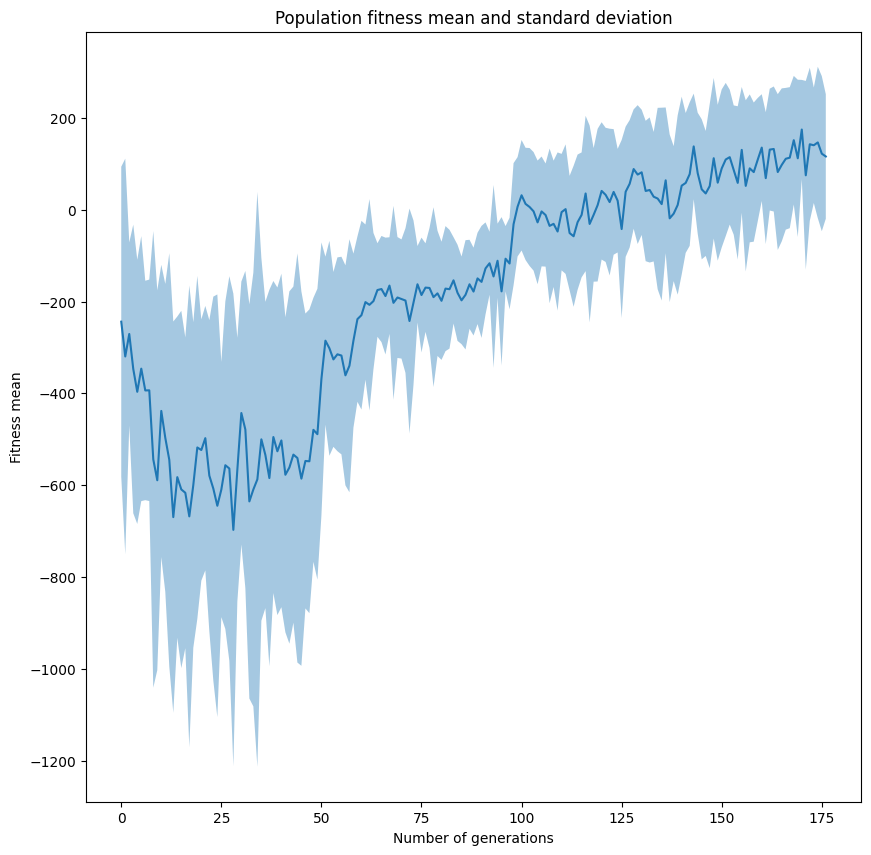

In [ ]:
save_path='/content/drive/MyDrive/GA/Lander_exp_v4'
initial_pop, model=generate_initial_pop(1)
ga=load_ga(save_path, fit_func, mutation_fn, crossover_fn, selection_fn, keep_parents=5)

fit_mean=[]
fit_std=[]
for el in ga.fitness_hist:
    fit_mean.append(el[2])
    fit_std.append(el[3])

fit_mean=np.array(fit_mean)
fit_std=np.array(fit_std)
plt.figure(figsize=(10,10))
plt.plot(fit_mean)
plt.fill_between(list(range(len(fit_mean))), fit_mean-fit_std, fit_mean+fit_std, alpha=0.4)
plt.savefig(save_path+'/pop_fitness.png')
plt.ylabel('Fitness mean')
plt.xlabel('Number of generations')
plt.title('Population fitness mean and standard deviation')
plt.show()

Let's visualize the trend of the best solution of the population at each epoch.

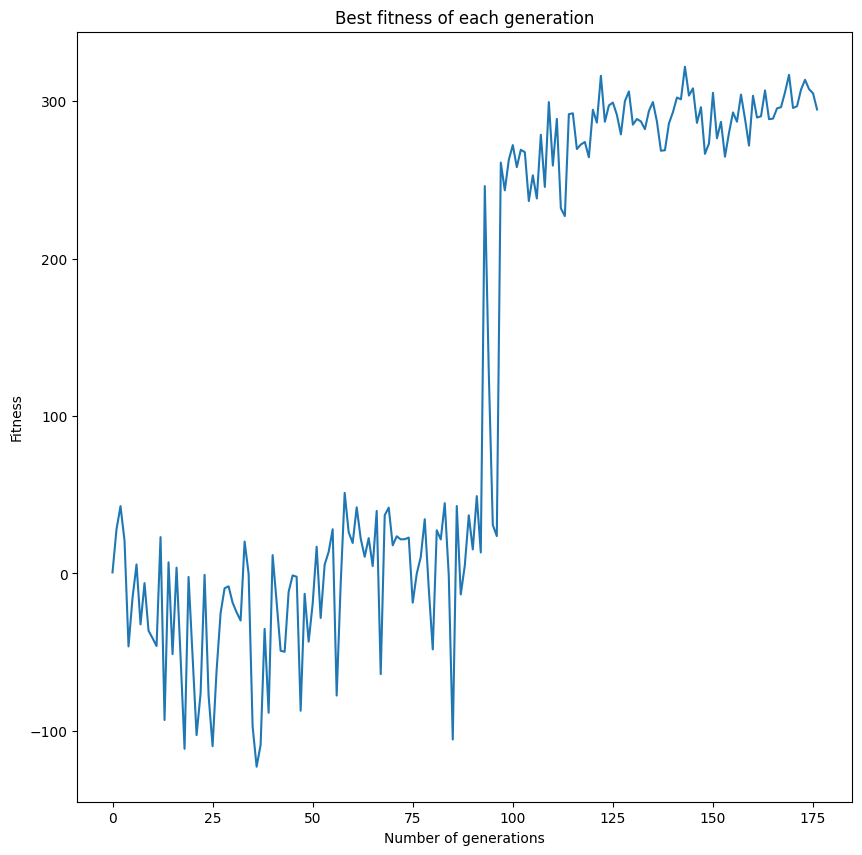

In [ ]:
current_best=[]

for el in ga.fitness_hist:
    current_best.append(el[1])

plt.figure(figsize=(10,10))
plt.plot(current_best)
plt.title('Best fitness of each generation')
plt.xlabel('Number of generations')
plt.ylabel('Fitness')
plt.show()

We observe that the best fitness of each generation presents a jump after around 100 generations after which it remains stable.

Let's visualize the performance of the best solution of the last epoch.

In [ ]:
#Current best solution
idx=np.argmax(ga.fitness)
current_best=ga.population[idx]
model.set_weights(reshape_weights(model,current_best))
create_policy_eval_video(model, env, str(ga.num_generations), num_episodes=5)


Episode reward: 253.18719495543405 Number of frames: 317
Episode reward: 244.95647359231168 Number of frames: 341
Episode reward: 233.2892733580281 Number of frames: 409
Episode reward: 258.63984944796346 Number of frames: 365
Episode reward: 240.60276796582207 Number of frames: 386


In [ ]:
reward, frames, success_rate =evaluate_policy(model, env, num_episodes=100)
reward_mean=np.mean(reward)
frames_mean=np.mean(frames)
print('Average reward in 100 episodes {}, average number of frames per episode {}'.format(reward_mean, frames_mean))
print('Success rate:', success_rate)

Episode reward: 284.7919601192578 Number of frames: 335
Episode reward: 244.39492894159739 Number of frames: 354
Episode reward: 236.5717776868927 Number of frames: 507
Episode reward: 222.68635309180655 Number of frames: 361
Episode reward: 292.3719668078502 Number of frames: 230
Episode reward: 254.64146505362882 Number of frames: 366
Episode reward: 254.68197520762436 Number of frames: 325
Episode reward: 293.3178763468964 Number of frames: 333
Episode reward: 295.9619308349346 Number of frames: 306
Episode reward: 269.0739183832976 Number of frames: 348
Episode reward: 243.4018137513853 Number of frames: 383
Episode reward: 279.0662034043877 Number of frames: 192
Episode reward: 264.2179384904085 Number of frames: 291
Episode reward: 256.1824495440007 Number of frames: 345
Episode reward: 297.03520722699733 Number of frames: 289
Episode reward: 251.6835539767335 Number of frames: 339
Episode reward: 271.0022637013657 Number of frames: 348
Episode reward: 226.05605723144907 Number o

The agent is able to obtain 200+ cumulative reward averaged over 100 episodes, indicating it can handle successfully a variety of situations.